# Acceleration Data Exploration

In [2]:
import numpy as np
import dataloader_halogaland.dataloader as dl
import matplotlib.pyplot as plt
import os
import scipy
from scipy import signal
import datetime

/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:

loader = dl.Dataloader(os.getcwd()+'/../Data/Halogaland_2022_04_22')
file = loader.read_file(loader.anodes[0])


In [4]:
acc = loader.load_acceleration(loader.acc_names[0], file)
print(file['acceleration_data']['A03-1y'].properties)

OrderedDict([('name', 'A03-1y'), ('description', 'y-dir of Geosig AC-73 force balance 3-axis accelerometer, SN: 58082. Mounted inside the bridge girder.'), ('position', '(-420.0, 7.7, 39.1)'), ('orientation', '(0, 1, 0)'), ('conversion_factor', '1.248'), ('unit_string', 'volt')])


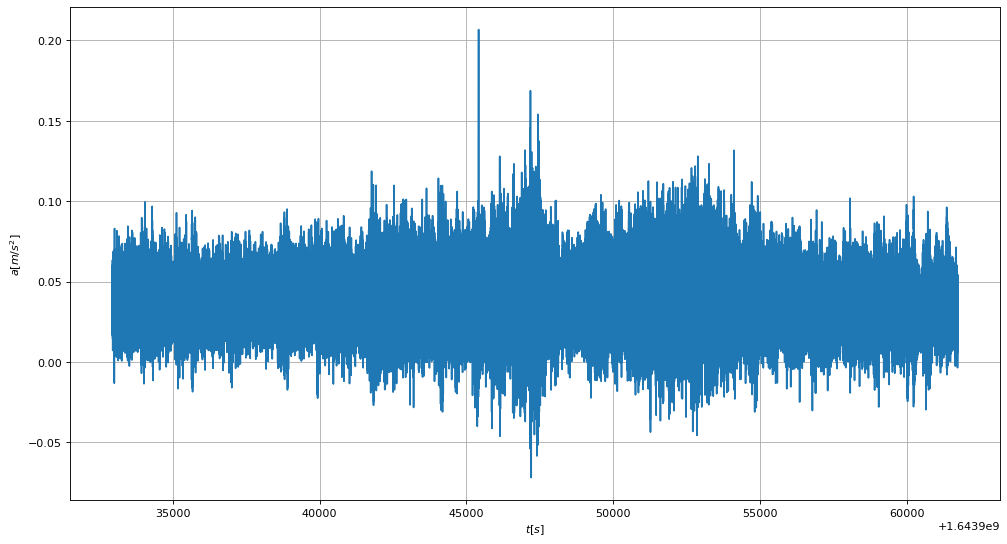

In [5]:
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(acc['timestamp'], acc['1y'])
plt.xlabel('$t [s]$')
plt.ylabel('$a [m/s^2]$')
plt.grid()
plt.show()

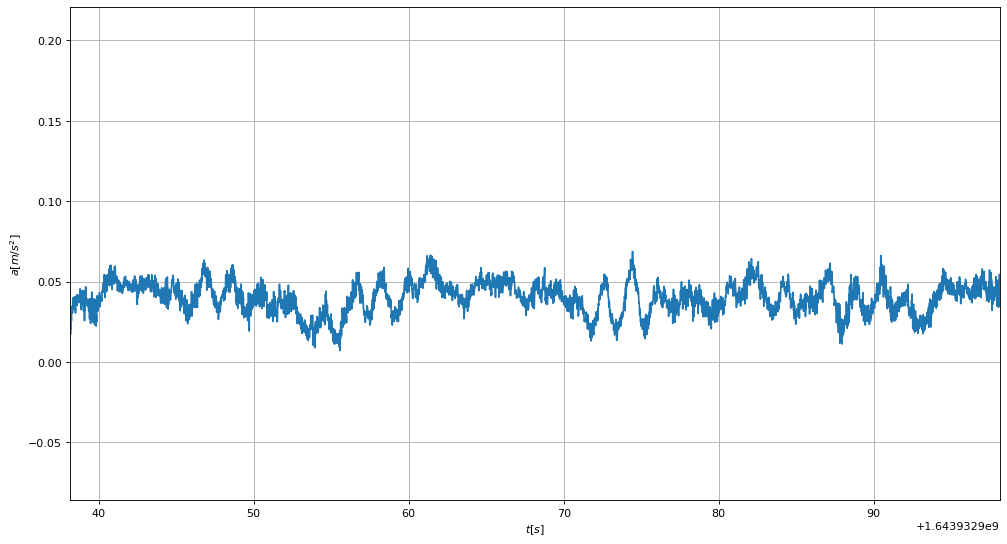

In [6]:
min = 1
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(acc['timestamp'], acc['1y'])
plt.xlabel('$t [s]$')
plt.ylabel('$a [m/s^2]$')
plt.grid()
plt.xlim([acc['timestamp'][0], acc['timestamp'][64*60*min]])
plt.show()

### Fourier transform to investigate the frequncy content

In [7]:
print(acc['timestamp'].shape[0])

1843200


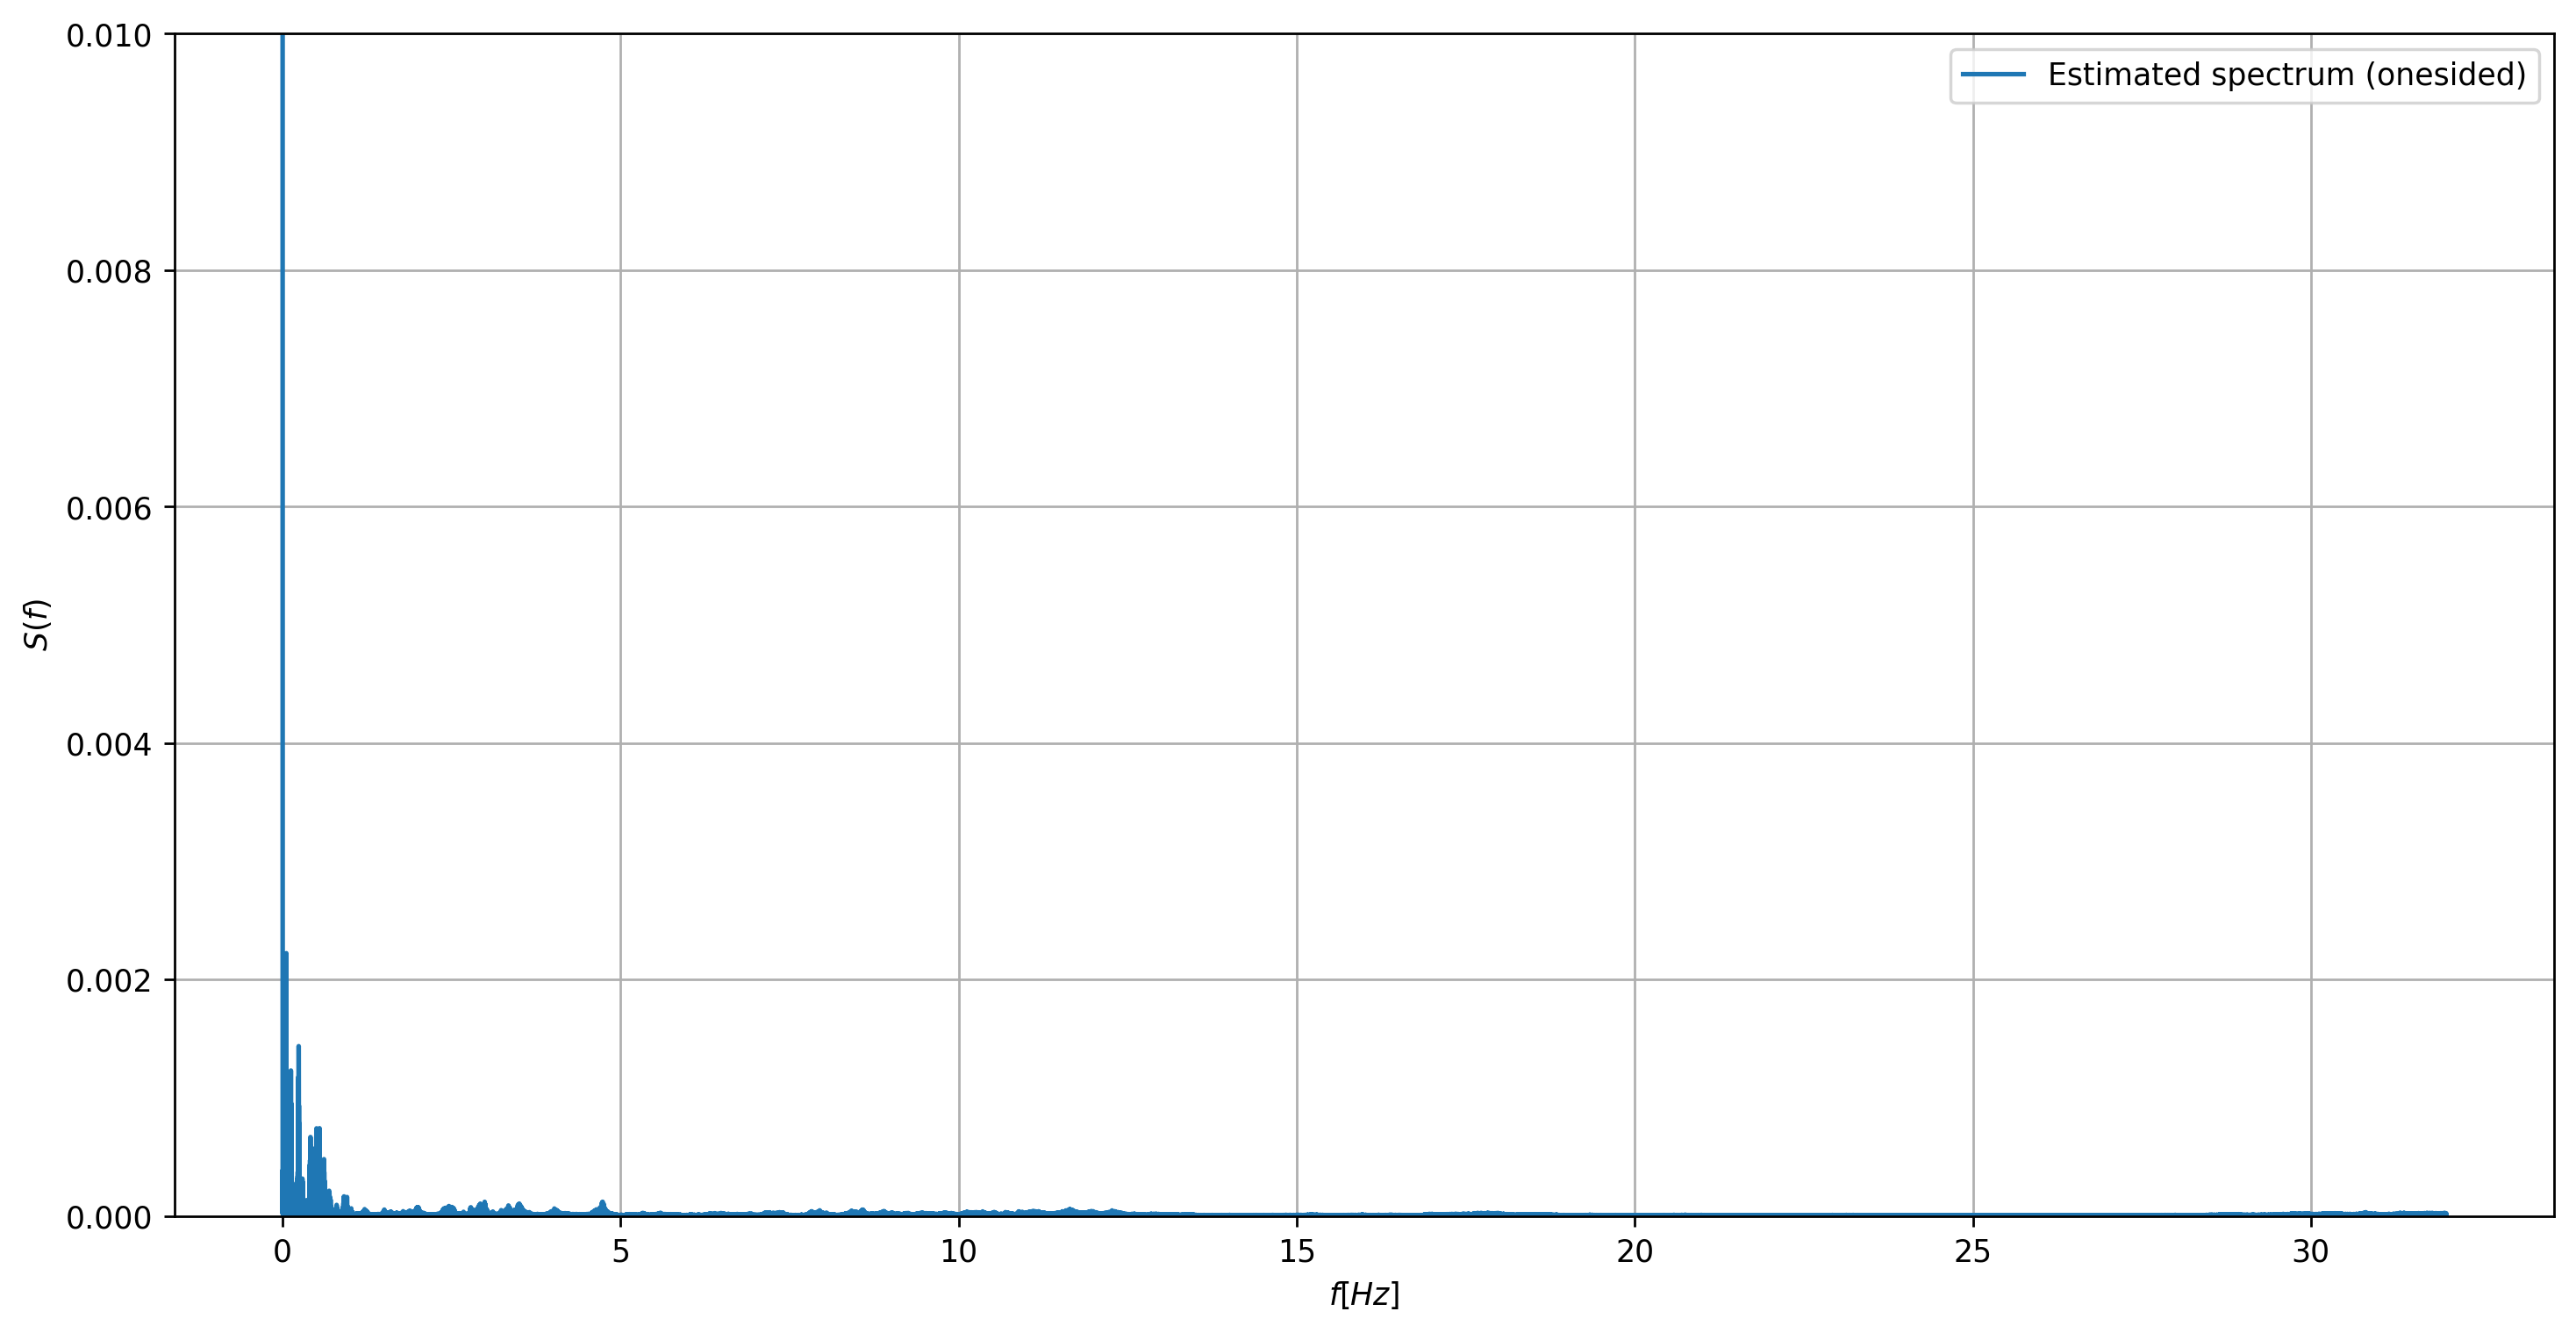

In [8]:
dt=acc['timestamp'][1]-acc['timestamp'][0] # Time step
"""
Xfft = np.fft.fft(acc['1y'])/acc['timestamp'].shape[-1]
Sx_est = np.fft.fftshift(Xfft) # This shifts the DFT negative f, mean, positive f: [-w 0 w]
f_est = np.linspace(-1/2/dt,1/2/dt,acc['timestamp'].shape[0]); # Frequency axis in Hz
"""



Sx_est = (2.0/len(acc['1y']))*np.fft.rfft(acc['1y'])
f_est = np.fft.rfftfreq(acc['1y'].shape[0],dt)

plt.figure(figsize=(14,7), dpi= 250)
plt.plot(f_est, np.abs(Sx_est) ,label = 'Estimated spectrum (onesided)')
plt.xlabel('$f [Hz]$')
plt.ylabel('$S(f)$')
plt.ylim([0, 0.01])
#plt.xlim([0, 5])
plt.grid()
plt.legend()

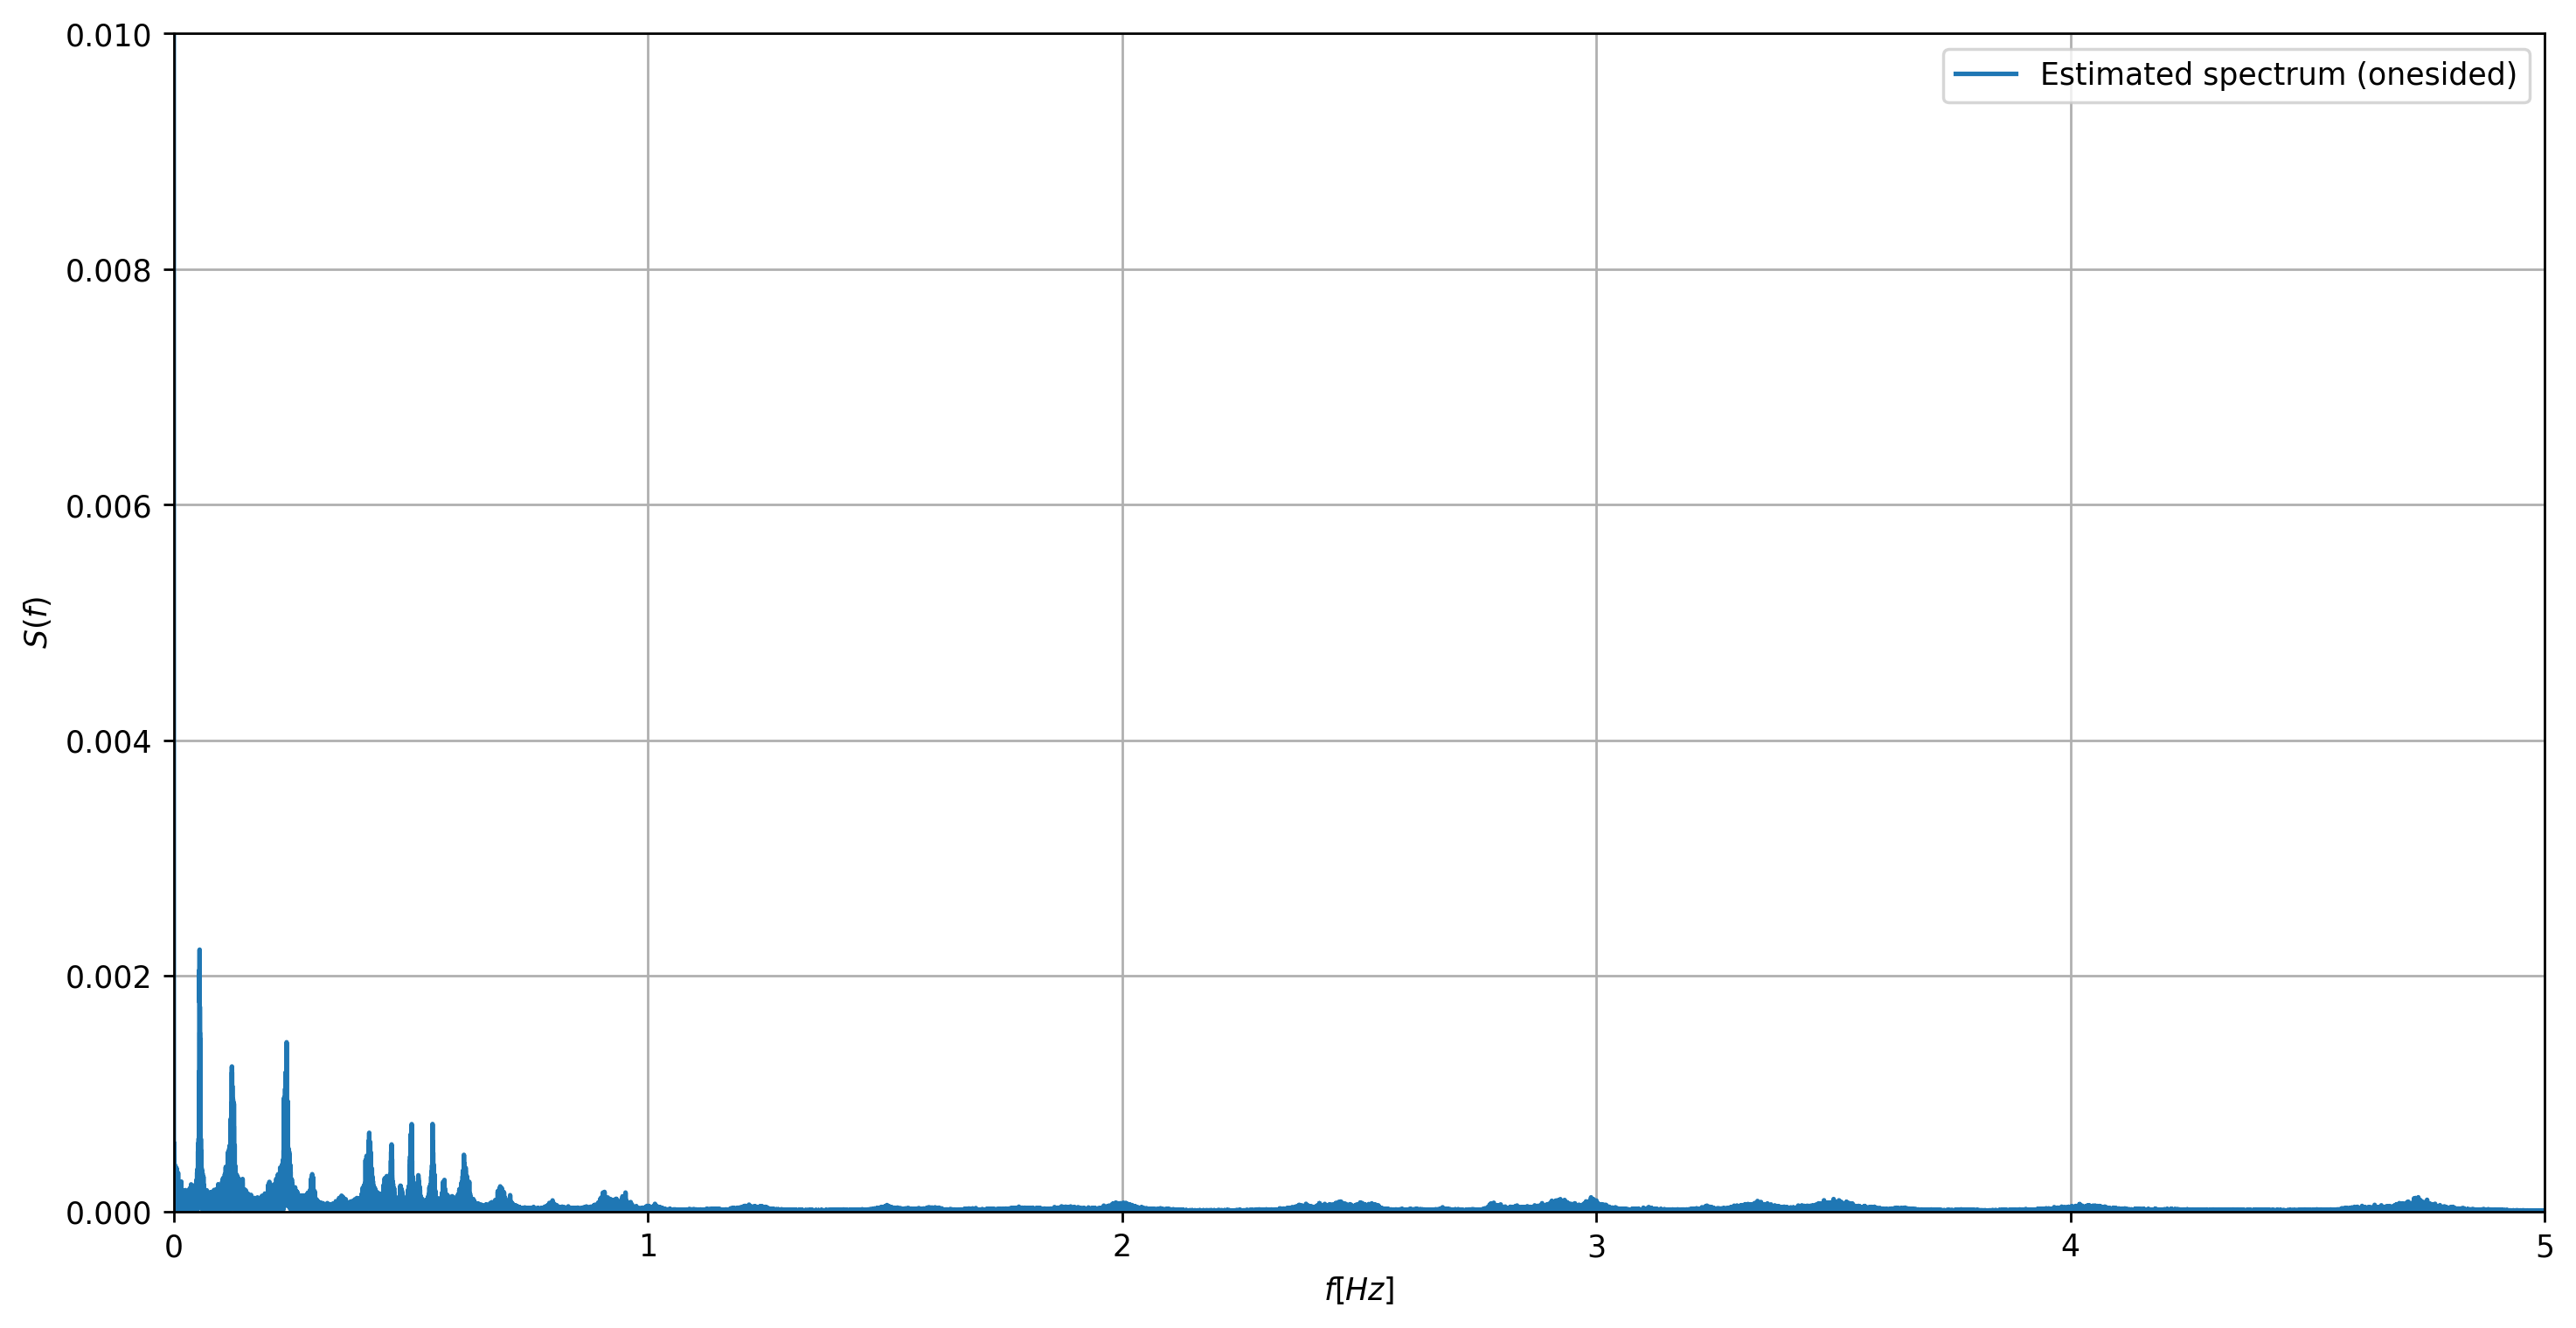

In [9]:
plt.figure(figsize=(14,7), dpi= 250)
plt.plot(f_est, np.abs(Sx_est) ,label = 'Estimated spectrum (onesided)')
plt.xlabel('$f$ [Hz]')
plt.ylabel('$S(f)$')
plt.ylim([0, 0.01])
plt.xlim([0, 5])
plt.grid()
plt.legend()

### Acceleration spectrum from Welch's method

64.0
16385


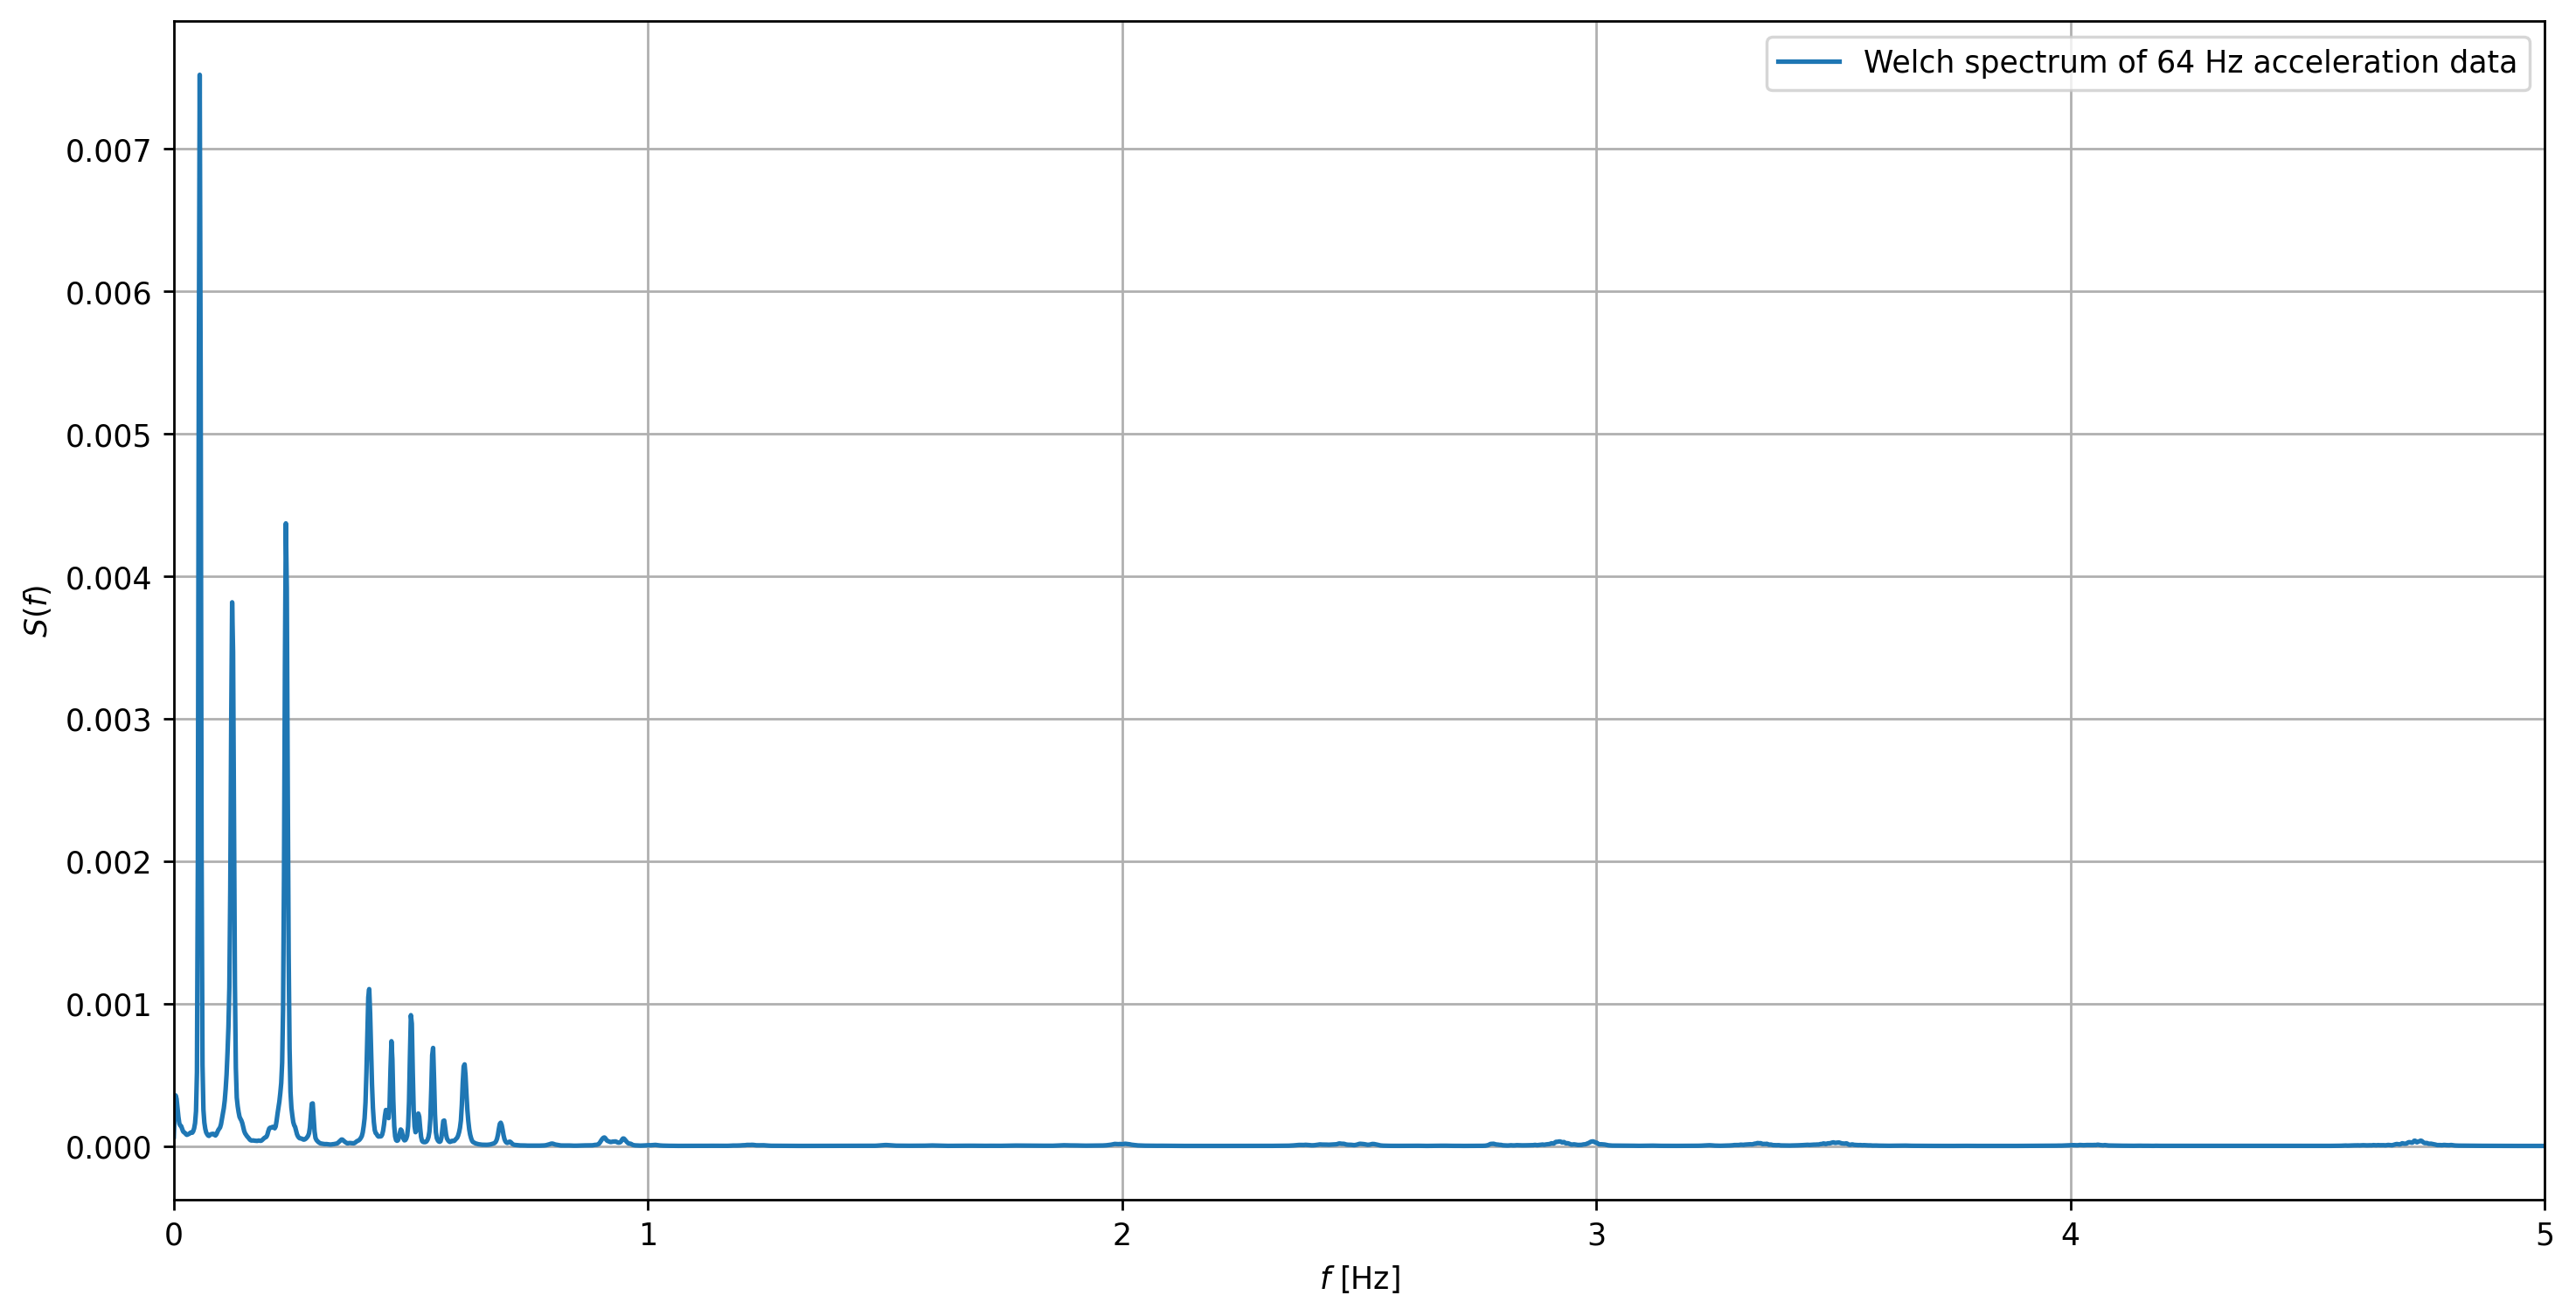

In [11]:
Ndivisions=100 # Number of divisions of the time series (total segments)
Nwindow=np.ceil(len(acc['timestamp'])/Ndivisions) # Length of window/segment

Nfft_pow2 = 2**(np.ceil(np.log2(Nwindow))) # Next power of 2 for zero padding
dt=acc['timestamp'][1]-acc['timestamp'][0] # Time step
print(1/dt)

# Call welch from scipy signal processing
f, Sx_welch=signal.welch(acc['1y'], fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')

print(len(f))
# Plot and compare with exact solution
plt.figure(figsize=(14,7), dpi= 250)
plt.plot(f,Sx_welch,label = 'Welch spectrum of 64 Hz acceleration data')
plt.xlabel('$f$ [Hz]')
plt.ylabel('$S(f)$')
#plt.yscale('symlog')
plt.xlim([0,5])
plt.grid()
plt.legend()
plt.savefig("welch_acceleration_freq_0-5_Hz.jpg")

### Constructing the auto correlation function

0.015625
64.0
0.015625
32768


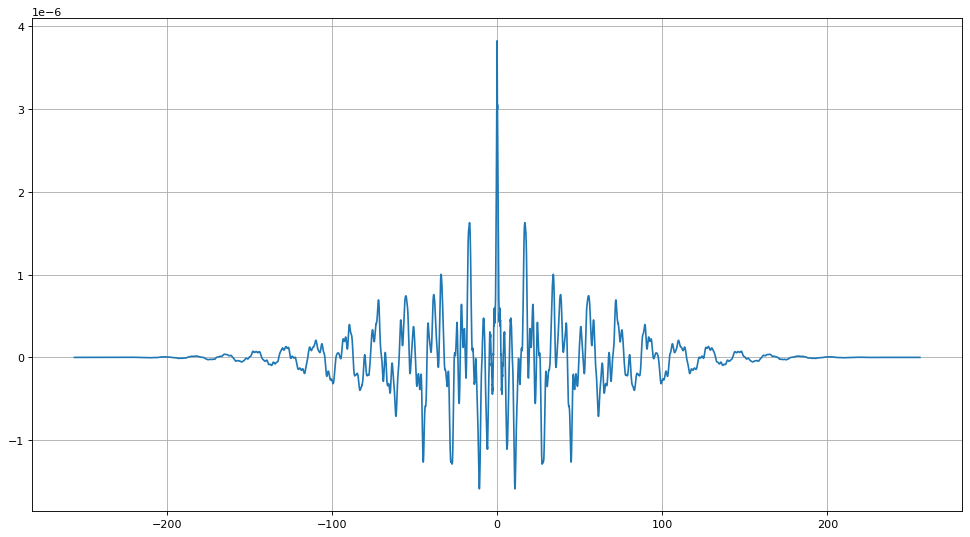

In [155]:
fi, Sx_welch=signal.welch(acc['1y'], fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=False, scaling='density', axis=- 1, average='mean')
print(dt)
print(1/dt)
var = np.var(acc['1y'])
acorr = np.fft.ifft(Sx_welch) #/var/len(acc['1y'])
acorr = np.fft.fftshift(acorr)
time_lag = np.arange(0,len(acorr))*dt
time_lag = time_lag - np.average(time_lag)
print(time_lag[-1]-time_lag[-2])

#acorr = acorr[time_lag>0]
#time_lag = time_lag[time_lag>0]

print(len(time_lag))

plt.figure(figsize=(15, 8), dpi=80)
plt.plot(time_lag, (acorr))
plt.grid()
#plt.xlim([0, 50])


(0.0, 50.0)

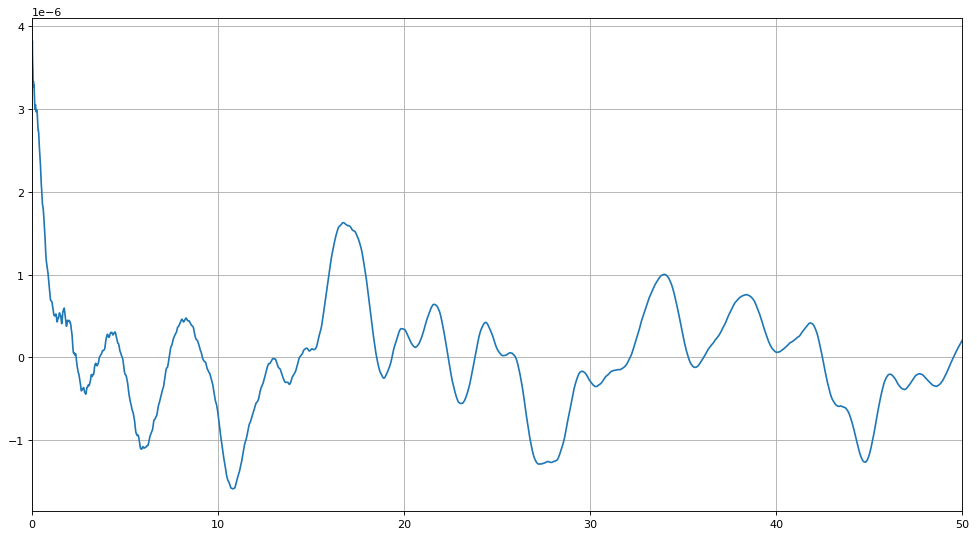

In [156]:
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(time_lag, (acorr))
plt.grid()
plt.xlim([0, 50])

### Applying a Butterworth filter as a lowpass filter

64.0


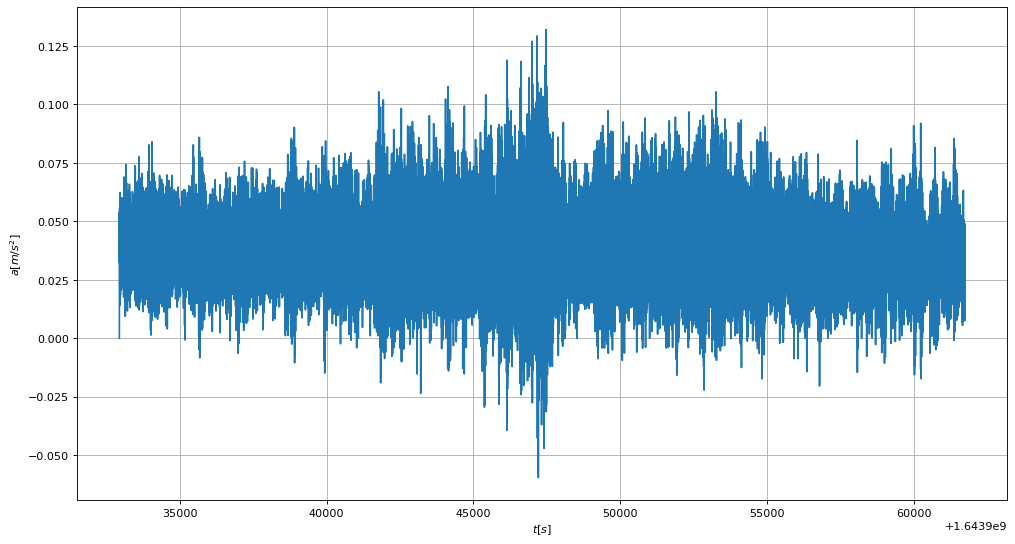

In [144]:
filter_order = 6
cutoff_frequency = 1

sampling_frequency = 1/dt
print(sampling_frequency)

sos = signal.butter(filter_order,cutoff_frequency,"low", fs=sampling_frequency, output='sos')

filtered_acc = signal.sosfilt(sos, acc['1y'])

plt.figure(figsize=(15, 8), dpi=80)
plt.plot(acc['timestamp'], filtered_acc)
plt.xlabel('$t [s]$')
plt.ylabel('$a [m/s^2]$')
plt.grid()
plt.show()

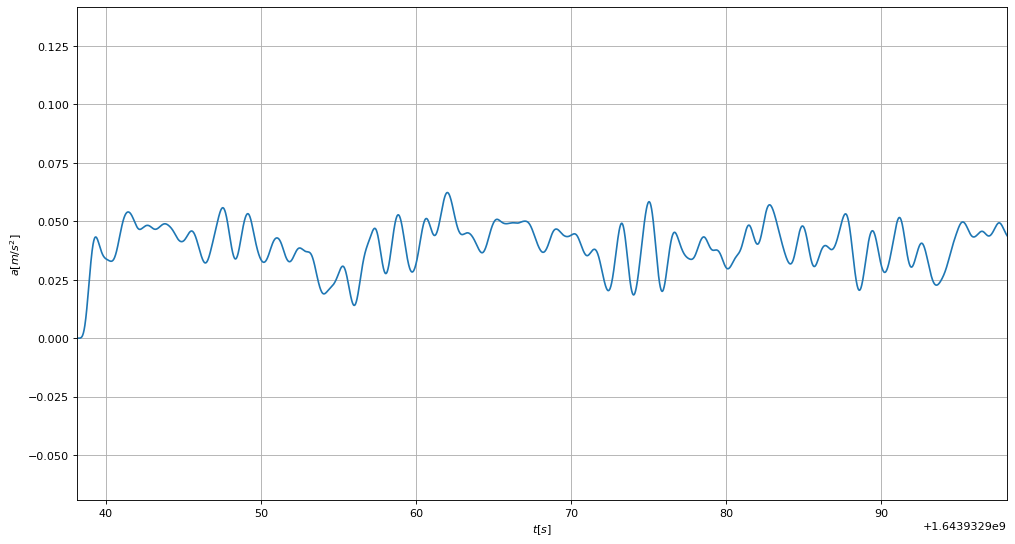

In [170]:
min = 1
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(acc['timestamp'], filtered_acc)
plt.xlabel('$t [s]$')
plt.ylabel('$a [m/s^2]$')
plt.grid()
plt.xlim([acc['timestamp'][0], acc['timestamp'][64*60*min]])
plt.show()

16385


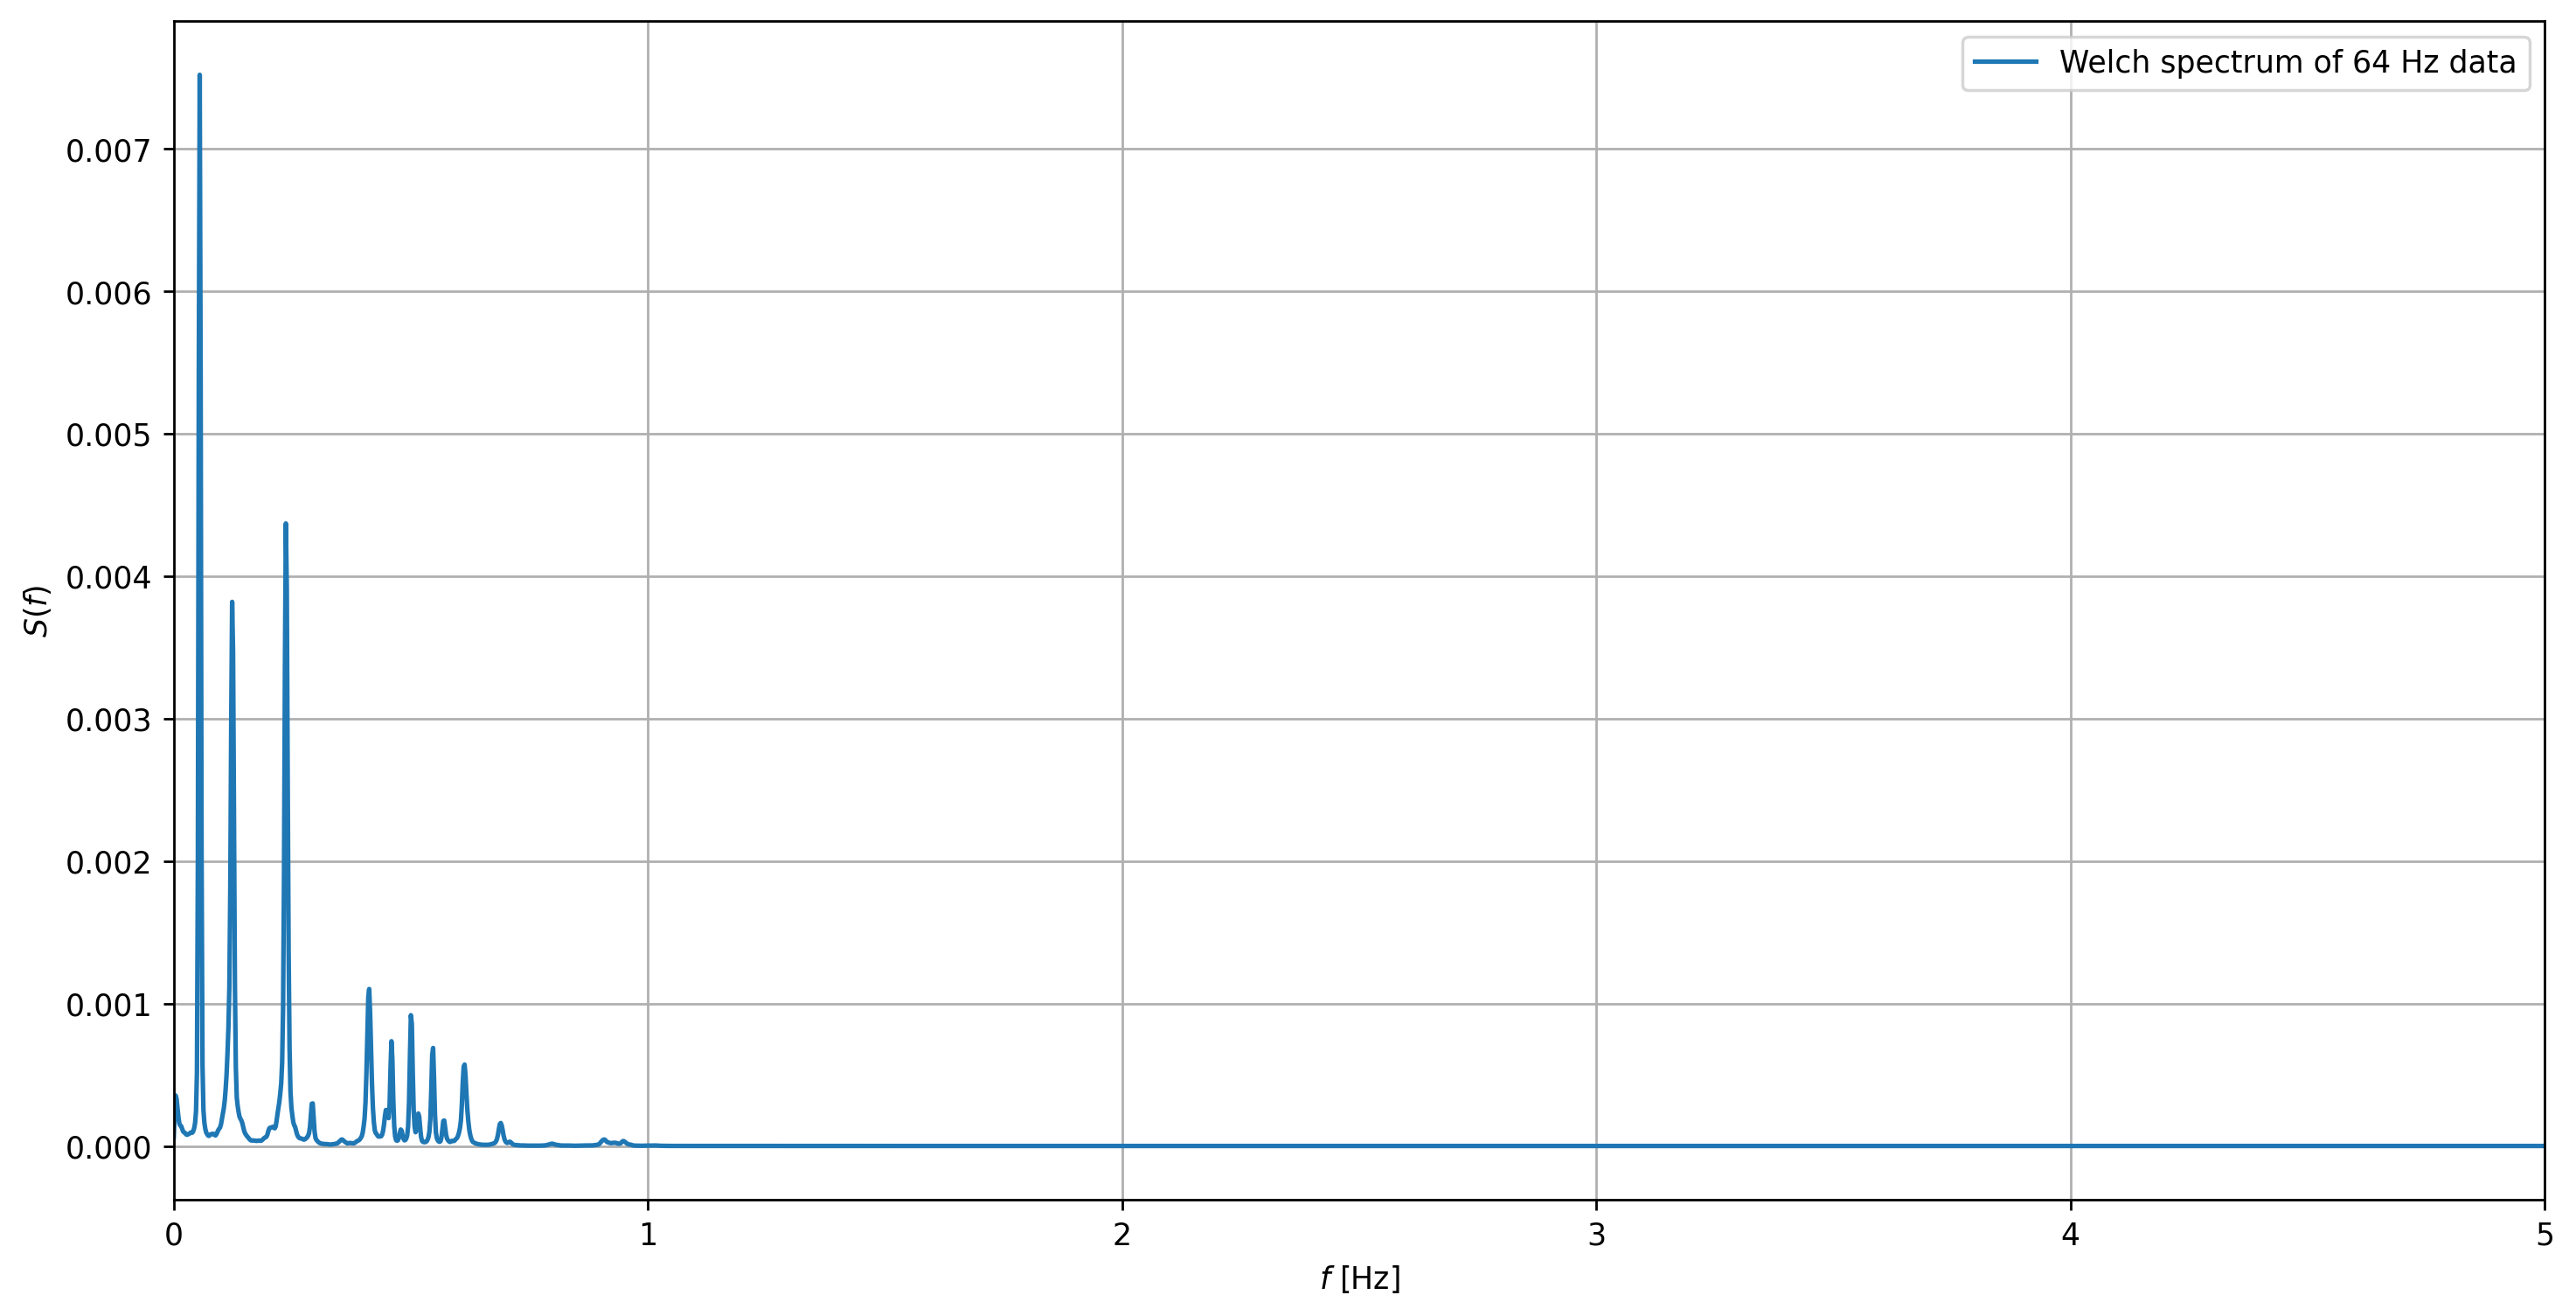

In [165]:
Ndivisions=100 # Number of divisions of the time series (total segments)
Nwindow=np.ceil(len(acc['timestamp'])/Ndivisions) # Length of window/segment

Nfft_pow2 = 2**(np.ceil(np.log2(Nwindow))) # Next power of 2 for zero padding
dt=acc['timestamp'][1]-acc['timestamp'][0] # Time step

# Call welch from scipy signal processing
f, Sx_welch=signal.welch(filtered_acc, fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')

print(len(f))
# Plot and compare with exact solution
plt.figure(figsize=(14,7), dpi= 250)
plt.plot(f,Sx_welch,label = 'Welch spectrum of 64 Hz data')
plt.xlabel('$f$ [Hz]')
plt.ylabel('$S(f)$')
#plt.yscale('symlog')
plt.xlim([0,5])
plt.grid()
plt.legend()
plt.savefig("welch_acceleration_freq_0-5_Hz.jpg")

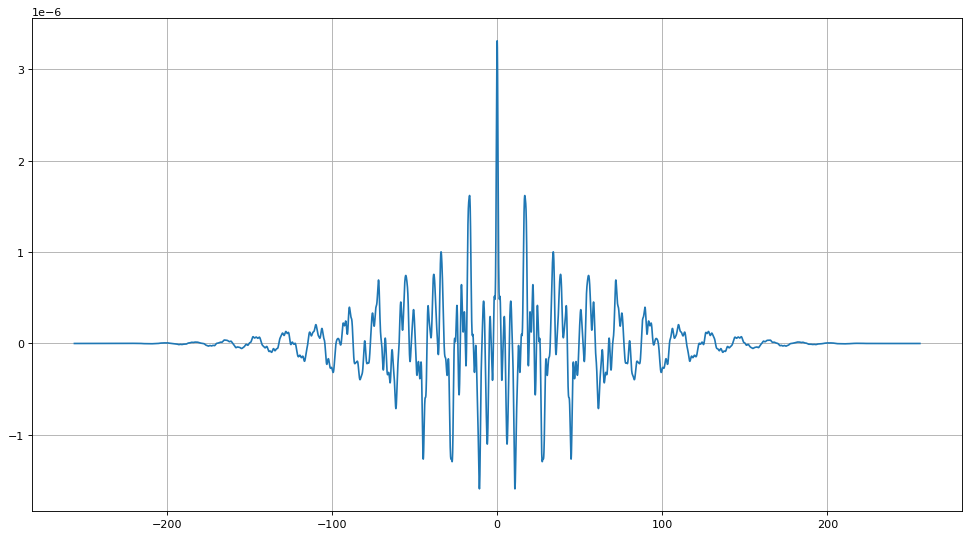

In [157]:
fi, Sx_welch=signal.welch(filtered_acc, fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=False, scaling='density', axis=- 1, average='mean')

var = np.var(filtered_acc)
acorr = np.fft.ifft(Sx_welch)
acorr = np.fft.fftshift(acorr)
time_lag = np.arange(0,len(acorr))*dt
time_lag = time_lag - np.average(time_lag)

plt.figure(figsize=(15, 8), dpi=80)
plt.plot(time_lag, (acorr))
plt.grid()
#plt.xlim([0, 50])

(0.0, 50.0)

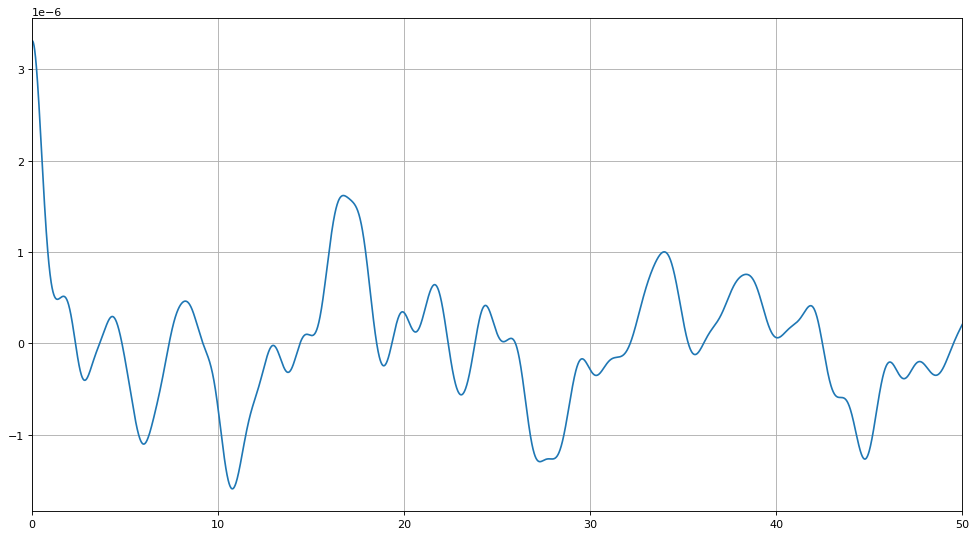

In [158]:
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(time_lag, (acorr))
plt.grid()
plt.xlim([0, 50])

In [ ]:
plt.figure(figsize=(15, 8), dpi=80)
plt.plot(time_lag, (acorr))
plt.grid()
plt.xlim([0, 50])

### Downsampling